# AGH Modelling of Physical Systems Lab 05 - assignment
Michał Szczygieł

## MPDATA

This notebook demonstrates the implementation of the MPDATA algorithm with support for an arbitrary number of corrective iterations. It includes simulations and visualizations to compare the accuracy of solutions with varying numbers of iterations.

In [7]:
'''MPDATA algorithm with support for an arbitrary number of corrective iterations'''
from typing import Optional
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [8]:
# pylint: disable=invalid-name,redefined-outer-name,missing-function-docstring

class Shift:
    '''
    A class to represent a shift operation for slices.
    '''
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

def F(psi_l, psi_r, c):
    return .5 * (c + abs(c)) * psi_l + \
           .5 * (c - abs(c)) * psi_r

def upwind(psi, i, c):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], c[i + hlf]) -
        F(psi[i - one], psi[i      ], c[i - hlf])
    )

def solve_upwind(*, nt: int, c: float, psi: np.ndarray):
    for _ in range(nt):
        upwind(psi, slice(1, len(c)), c)
    return psi

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)

def plot(x,
         title: Optional[str] = None,
         xlabel: Optional[str] = None,
         ylabel: Optional[str] = None,
         **kwargs):
    for label, data in kwargs.items():
        pyplot.step(x, data, label=label, where='mid')
    if title:
        pyplot.title(title)
    if xlabel:
        pyplot.xlabel(xlabel)
    if ylabel:
        pyplot.ylabel(ylabel)
    pyplot.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    pyplot.grid()
    show_plot()

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Computes the Root Mean Squared Error (RMSE) between true and predicted values.

    Args:
        y_true (np.ndarray): Array of true values.
        y_pred (np.ndarray): Array of predicted values.

    Returns:
        float: RMSE value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [9]:
class MPDATA:
    '''
    MPDATA algorithm with support for an arbitrary number of corrective iterations.
    '''
    def __init__(self, *, nt: int,  psi: np.ndarray, c: np.ndarray, iterations: int = 1):
        self.nt = nt
        self.c = c
        self.psi = psi
        self.iterations = iterations

        self.results = {}

    def corrective_courant_number(self, psi: np.ndarray, c: np.ndarray, i: slice):
        return (np.abs(c[i-hlf]) - c[i-hlf]**2) * (psi[i] - psi[i-one]) / (psi[i] + psi[i-one])

    def solve(self, psi: np.ndarray, iterations: int = 1) -> None:
        i = slice(1, len(self.c))
        i_ext = slice(1, len(psi))

        for _ in range(self.nt):
            upwind(psi, i, self.c)
            corr_c = self.c
            for _ in range(iterations):
                corr_c = self.corrective_courant_number(psi, corr_c, i_ext)
                upwind(psi, i, corr_c)

        return psi

    def __call__(self):
        for i in range(1, self.iterations + 1):
            self.results[f'MPDATA (iteration={i})'] = self.solve(self.psi.copy(), iterations=i)

        return self.results

    def compare_with_analytical(self, analytical: np.ndarray) -> None:
        errors = []

        for data in self.results.values():
            rmse_value = rmse(analytical, data)
            errors.append(rmse_value)

        return errors

In [10]:
u = 2
t_max = 66

nx = 45
nt = 100
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

initial=psi_0(x)
analytic=psi_0(x-u*t_max)
mpdata = MPDATA(
    nt=nt,
    psi=psi_0(x),
    c=np.full(nx-1, u * dt / dx),
    iterations=10
)
results = mpdata()

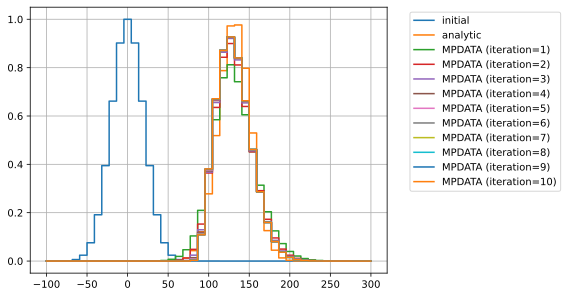

In [11]:
plot(
    x=x,
    initial=initial,
    analytic=analytic,
    **results
)

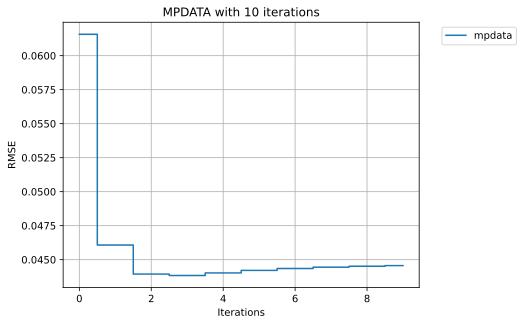

In [12]:
plot(
    x=np.arange(mpdata.iterations),
    mpdata=mpdata.compare_with_analytical(analytical=analytic),
    xlabel='Iterations',
    ylabel='RMSE',
    title=f'MPDATA with {mpdata.iterations} iterations'
)

## Conclusion

From the results, it is evident that performing corrections beyond the 3rd iteration does not significantly improve the accuracy of the solution. The RMSE values after the 3rd iteration are slightly increasing, indicating diminishing returns for additional iterations.